# IND5022 Notebook
# Classification model of heartdiease and following data analysis
## Group NO: 2
### Members
### Tian Shuo &emsp; Wu Jinqian &emsp; Zhang Wentao &emsp; Yang Leying &emsp; Mo Xixi &emsp; Du Zhouyang

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix
import xgboost
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

##### **box_plot_outliers:** The box graph method to detect and remove outliers <p>

**Parameters** <p>
        *data_ser:* The dataset to perform outlier detection on. Receive pandas.Dataframe data format<p>
        *box_scale:* Box line chart scale, box is used by default scale=3 for cleaning <p>
        *col:* The specific feature to perform box graph analysis<p>
    **Returns** <p>
        *outlier:* The ouliers of input dataset, in pandas.Dataframe data format.<p>
        *normal_value:* The residuals of data after outliers removemnent, in pandas.Dataframe data format.<p>
        *(val_low, val_up):* A tuple that contains the lower limit and upper limit for outlier detection, in float type.

In [2]:
def box_plot_outliers(data_ser, box_scale,col):
    iqr = box_scale * (data_ser[col].quantile(0.75) - data_ser[col].quantile(0.25))
    val_low = data_ser[col].quantile(0.25) - iqr*1.5
    val_up = data_ser[col].quantile(0.75) + iqr*1.5
    outlier = data_ser[(data_ser[col] < val_low) | (data_ser[col] > val_up)]
    normal_value = data_ser[(data_ser[col] > val_low) & (data_ser[col] < val_up)]
    return outlier, normal_value, (val_low, val_up)

This method to encode 'Yes' or 'No' features into 1 and 0, for further data analysis

In [38]:
def binary_encoding(data, targetList):
    for target in targetList:
        booleanCol = data[target].apply(lambda x: 1 if x=='Yes' else 0)
        data = data.drop(target, axis=1)
        data.insert(1, target, booleanCol)
    return data

This method to perform multicollinearity check based on VIF value

In [114]:
def get_vif(data, target):
    X = data.drop(target, axis=1)
    X['constant'] = 1
    y = data[target]
    vif_info = pd.DataFrame()
    vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_info['Column'] = X.columns
    return vif_info.sort_values('VIF', ascending=False)

### A brief introduction to our dataset

Our dataset contains an initial 300703 samples, a target dependent variable HeartDisease, and features that are related to each individual's health status, living habbits, sex, race, and age 

Our dataset comes from Kaggle, collected by the US Centers for Disease Control and Prevention (CDC) through telephone survey. There are nearly 300 variables in the original dataset. After some pre-processing that is not done by us, these 300 variables are reduced to about 20 variables, which is the dataset used by our group now

In [54]:
data=pd.read_csv(r'D:\semester1\IND5022\pythonProject\heart_2020.csv')
data.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [68]:
data.describe()

,SkinCancer,Diabetic,HeartDisease,KidneyDisease,Asthma,PhysicalActivity,DiffWalking,Stroke,AlcoholDrinking,Smoking,...,GenHealth,SleepTime,Sex_Female,Sex_Male,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White
count,300703.000000,300703.000000,300703.000000,300703.000000,300703.000000,300703.000000,300703.000000,300703.000000,300703.000000,300703.000000,...,300703.000000,300703.000000,300703.000000,300703.000000,300703.000000,300703.000000,300703.000000,300703.000000,300703.000000,300703.000000
mean,0.097249,0.134528,0.090398,0.038979,0.141445,0.763774,0.146670,0.039920,0.071649,0.422520,...,2.221099,7.074728,0.529014,0.470986,0.017210,0.026541,0.075486,0.089836,0.036112,0.754815
std,0.296297,0.341219,0.286752,0.193544,0.348481,0.424764,0.353777,0.195771,0.257906,0.493961,...,1.511412,1.425610,0.499158,0.499158,0.130052,0.160738,0.264175,0.285947,0.186569,0.430198
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,4.000000,8.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,4.000000,16.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Datapreprocessing

**1. Check whether there is any sample that contains null value in our dataset**

In [55]:
data.isnull().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

**2. Feature encoding for our yes-or-no and category featrues.**<p>
    
* For binary features like 'Smoking', 'AlcoholDrinking', 'Stroke' etc, they are encoded by 1 and 0.
* For category features that have limited numbers of categories but do not have a clear internal order, like 'Sex','Race', they are encoded by one-hot encoding.<p>
* For category features whose values have a clear order or sequence, like 'AgeCategory', 'GenHealth', are encoded by label encoding.

In [56]:
binaryFeatures = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer',
                  'HeartDisease', 'Diabetic']
data = binary_encoding(data, binaryFeatures)

In [57]:
data=pd.get_dummies(data,columns=['Sex','Race'],drop_first=False)

In [58]:
La = LabelEncoder()
data['AgeCategory']=La.fit_transform(data['AgeCategory'])
data['GenHealth']=La.fit_transform(data['GenHealth'])

Our data after feature encoding

In [59]:
data.head()

,SkinCancer,Diabetic,HeartDisease,KidneyDisease,Asthma,PhysicalActivity,DiffWalking,Stroke,AlcoholDrinking,Smoking,...,GenHealth,SleepTime,Sex_Female,Sex_Male,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White
0,1,1,0,0,1,1,0,0,0,1,...,4,5.0,1,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0,1,0,0,...,4,7.0,1,0,0,0,0,0,0,1
2,0,1,0,0,1,1,0,0,0,1,...,1,8.0,0,1,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,...,2,6.0,1,0,0,0,0,0,0,1
4,0,0,0,0,0,1,1,0,0,0,...,4,8.0,1,0,0,0,0,0,0,1


**3. Using box graph method for outlier detection and removement**
* Outlier detection is performed based on BMI and sleeptime of each individual.
* If any sample contained an abnormal value of BMI or sleeptime, it will be considered as an outlier and removed.
* For people whose sleeptime is too short, they maybe have other sleep-related disease and not be considered in our analysis; for those who have too long sleeptime, they maybe in a comma, so they are also removed from the analysis.
* Our model is built target at normal people who wants to see if they have potential heartdisease, samples with abnormal BMI values may affects the generalization performance of the model, thus, they are removed too.

In [60]:
len1 = len(data)
outlier_BMI, normal_value_BMI, value = box_plot_outliers(data, 3,'BMI')
outlier_SleepTime, normal_value_SleepTime, value = box_plot_outliers(normal_value_BMI, 3,'SleepTime')
data=normal_value_SleepTime
len2 = len(data)
print("The original sample size is ",{len1})
print("The after-outlier-removement sample size is ",{len2})

The original sample size is  {319795}
The after-outlier-removement sample size is  {319332}


**4. Check if there are some duplicates in the data and drop the duplicates.**

In [61]:
data.drop_duplicates(inplace=True)
print("The sample size after droping duplicate is ",{len(data)})

The sample size after droping duplicate is  {300703}


C:\Users\86138\AppData\Local\Temp\ipykernel_73636\1689449.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(inplace=True)


**5. Check for the corrleation among our features now, and perform a vif check on our features excluding those encoded by one-hot encoding.**<p>

The correlation heatmap of our encoded features is shown below.<p>
* Because of the numbers of features, during visualization, we round the correlation coefficient to 1 decimal place to observe the relationship between different features more intuitively.<p>
* There are two features whose corrlation is -1, thay are sex_male and sex_female after one-hot encoding with gender feature.<p>
* We can tell from the heatmap that the correlations are not quite strong among our faetures, which may indicate there is perhaps no multicollinearity problem in our dataset. We visualize the vif value of features to further prove this.

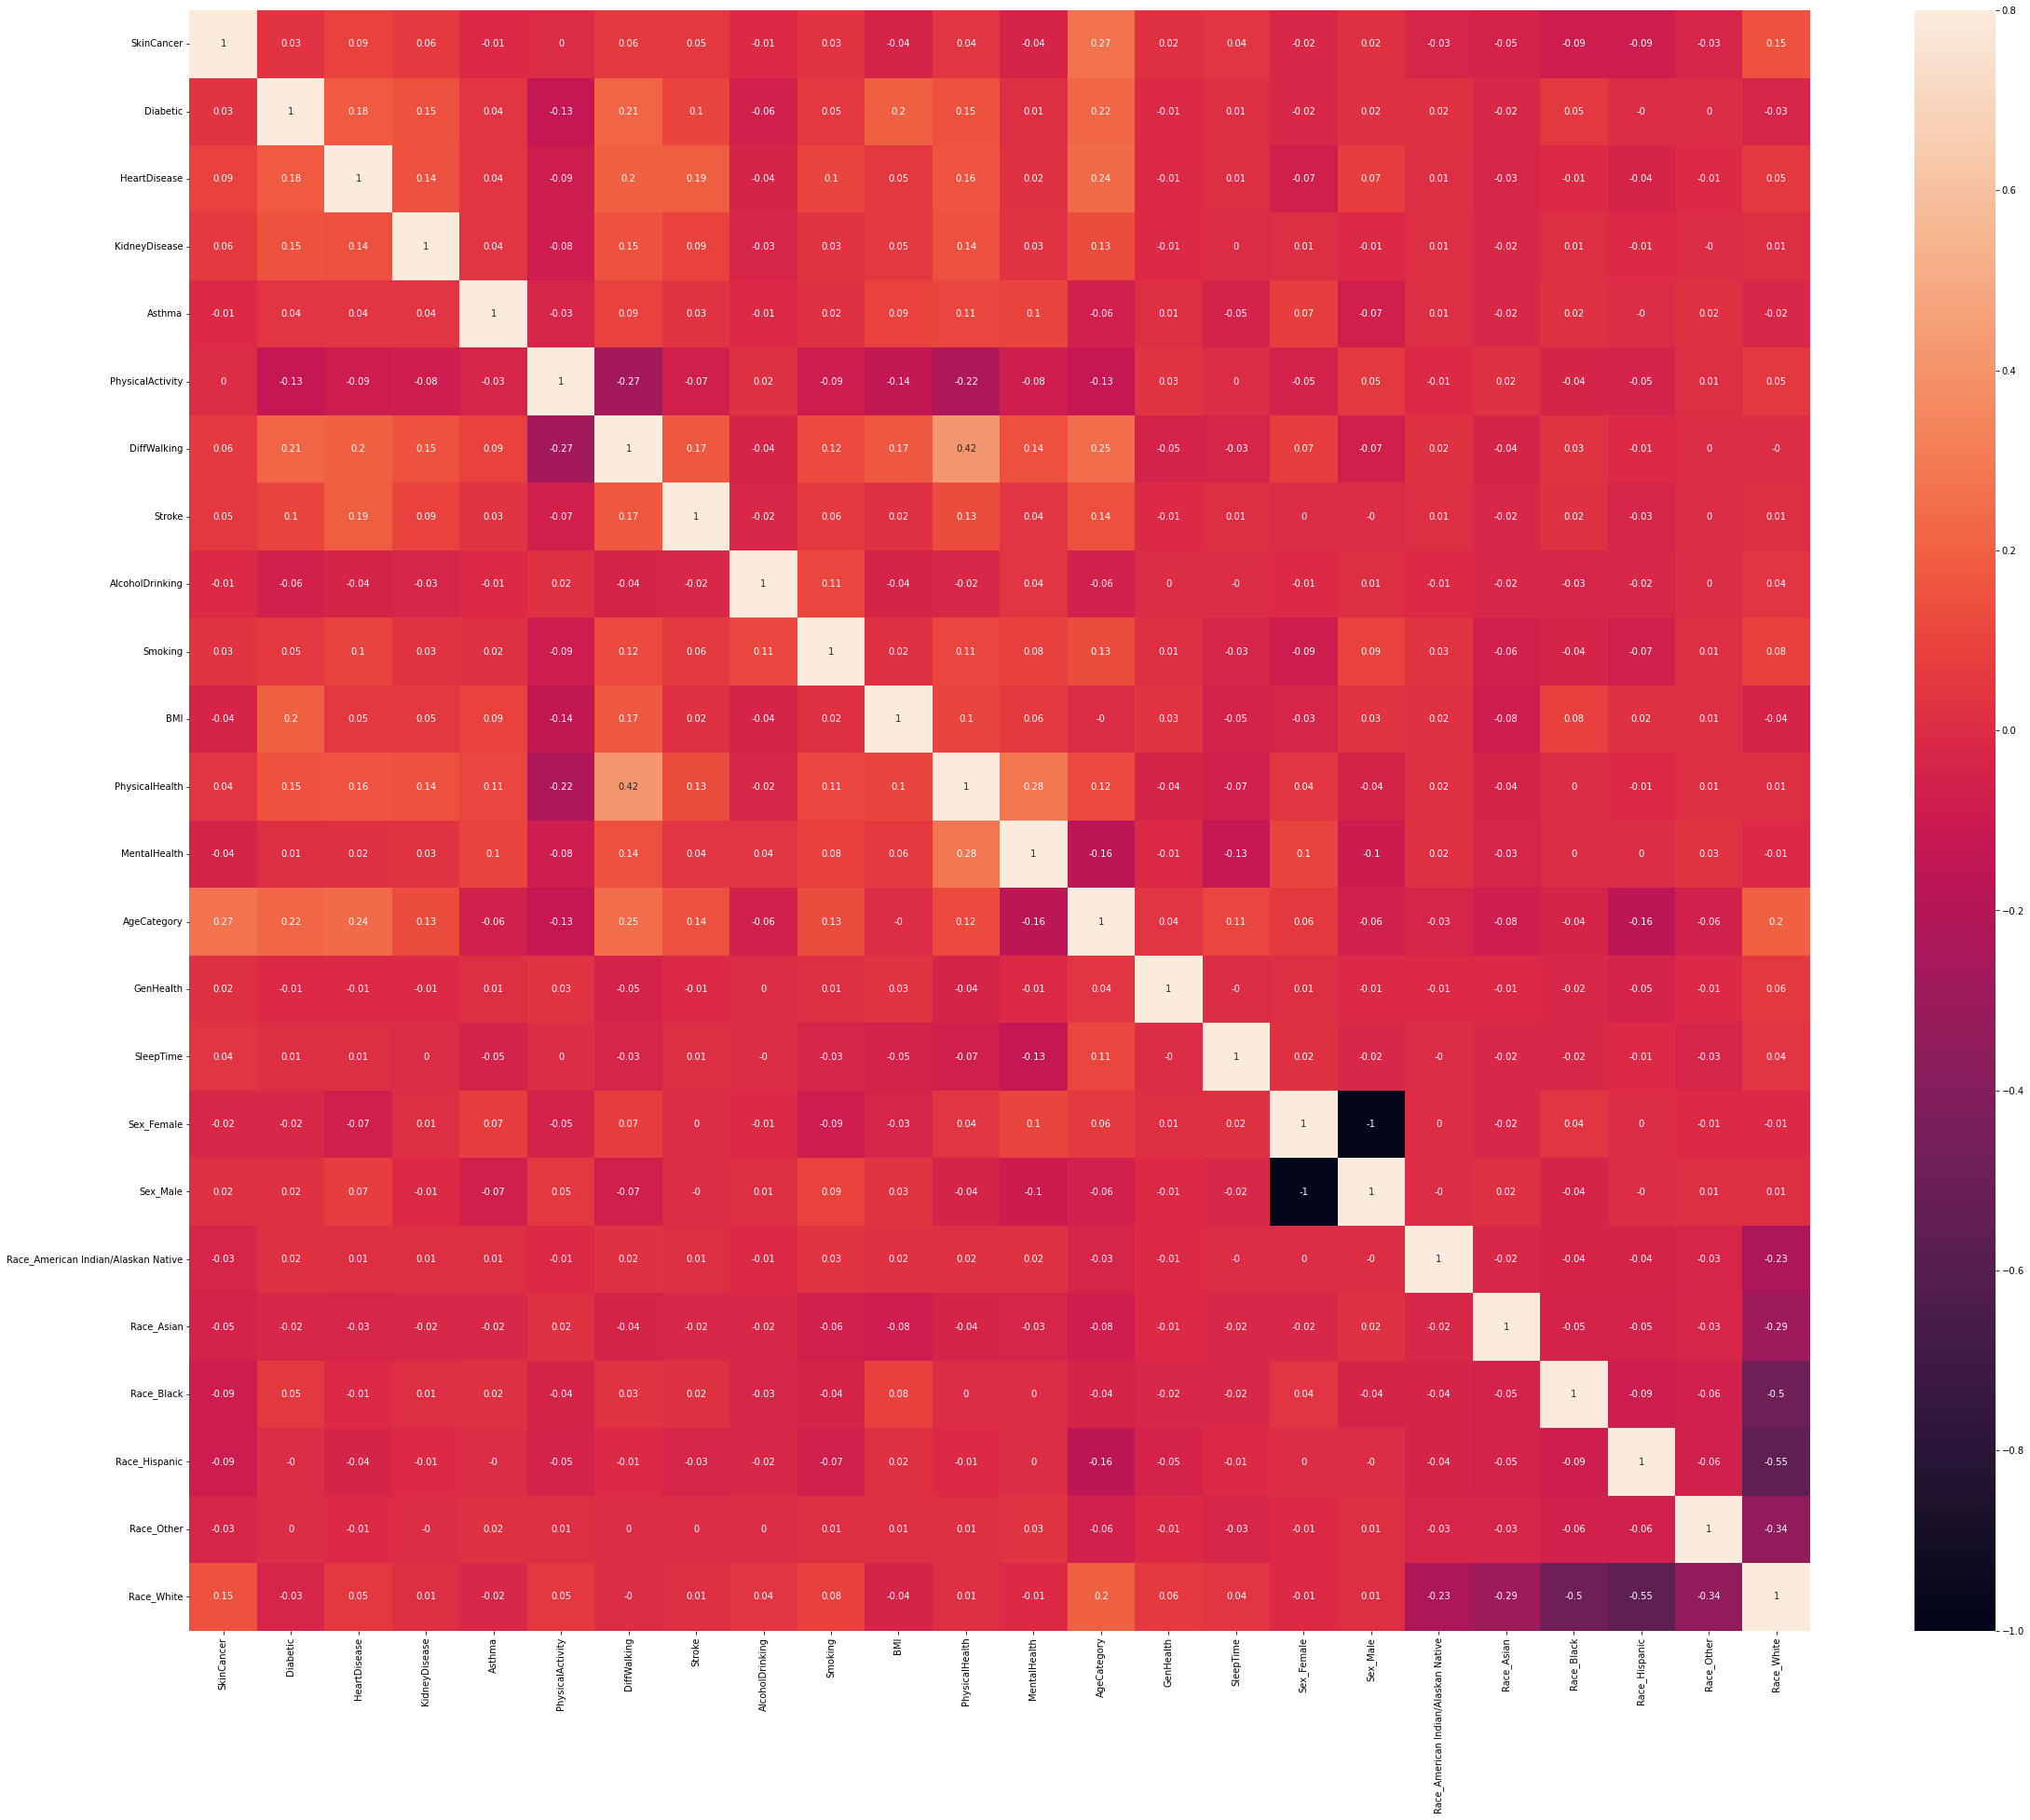

In [113]:
corr = data.corr().round(2)
ax = plt.subplots(figsize=(40, 32))
ax = sns.heatmap(corr, vmax=.8, square=True, annot=True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Next we perform VIF check on our features.

In [115]:
vif = get_vif(data, 'HeartDisease')
print("VIF of features: \n")
print(vif)

C:\Users\86138\.conda\envs\IND5003\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


VIF of features: 

         VIF                               Column
15       inf                           Sex_Female
22       inf                           Race_White
21       inf                           Race_Other
20       inf                        Race_Hispanic
19       inf                           Race_Black
18       inf                           Race_Asian
17       inf  Race_American Indian/Alaskan Native
16       inf                             Sex_Male
5   1.395332                          DiffWalking
12  1.355353                          AgeCategory
10  1.339289                       PhysicalHealth
11  1.173216                         MentalHealth
1   1.146816                             Diabetic
4   1.127959                     PhysicalActivity
9   1.103298                                  BMI
0   1.096915                           SkinCancer
8   1.076135                              Smoking
2   1.054538                        KidneyDisease
6   1.054113                   

C:\Users\86138\.conda\envs\IND5003\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


As we can see, there are many inf value, which means the features after one-hot encoding exits a large multicollinearity.<p>
    We eliminate the features of Sex_Female, Race_White, Race_Other, and see if the multicollinearity problem still exits.

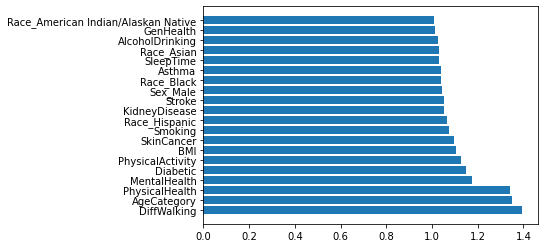

VIF of features: 

          VIF                               Column
20  64.892269                             constant
5    1.395092                          DiffWalking
12   1.348585                          AgeCategory
10   1.339267                       PhysicalHealth
11   1.173204                         MentalHealth
1    1.146562                             Diabetic
4    1.127959                     PhysicalActivity
9    1.103295                                  BMI
0    1.095909                           SkinCancer
8    1.076059                              Smoking
19   1.065891                        Race_Hispanic
2    1.054537                        KidneyDisease
6    1.054024                               Stroke
15   1.042742                             Sex_Male
18   1.040774                           Race_Black
3    1.037733                               Asthma
14   1.031738                            SleepTime
17   1.031620                           Race_Asian
7    1.02699

In [118]:
df_vif = data.drop('Sex_Female', axis=1)
df_vif = df_vif.drop('Race_White', axis=1)
df_vif = df_vif.drop('Race_Other', axis=1)
vif = get_vif(df_vif, 'HeartDisease')
val = vif['VIF'][1:].values
col = vif['Column'][1:].values
plt.barh(col, val)
plt.show()
print("VIF of features: \n")
print(vif)

As is shown, the biggest vif value decreases to about 1.4. So by removing these three features we basically slove the multicollinearity problem.

In [120]:
data = data.drop('Sex_Female', axis=1)
data = data.drop('Race_White', axis=1)
data = data.drop('Race_Other', axis=1)

**6. Some visulization of our dataset based on how human living habbits affects the chance of having heart disease**

The relationship between the obesity of humans and the chance of getting heart disease

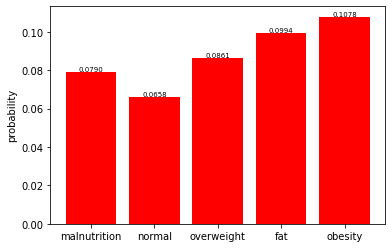

In [129]:
df = data
df_bmi_malnutrition = df[df['BMI'] < 18.5]
df_bmi_normal = df[(df['BMI'] >= 18.5) & (df['BMI'] <= 23.9)]
df_bmi_overweight = df[(df['BMI'] > 23.9) & (df['BMI'] <= 27)]
df_bmi_fat = df[(df['BMI'] > 27) & (df['BMI'] <= 32)]
df_bmi_obesity = df[df['BMI'] > 32]
bmi_list = [df_bmi_malnutrition, df_bmi_normal, df_bmi_overweight, df_bmi_fat, df_bmi_obesity]
bmi_type = ['malnutrition', 'normal', 'overweight', 'fat', 'obesity']
bmi_heart_disease_prob = []
for df in bmi_list:
    bmi_heart_disease_prob.append(len(df[df['HeartDisease'] == 1]) / len(df))
pd_bmi_sta = pd.Series(bmi_heart_disease_prob, index=bmi_type)

plt.figure()
index=np.arange(len(bmi_type))
plt.bar(pd_bmi_sta.index, pd_bmi_sta.values, color='red')
for a, b in zip(index,pd_bmi_sta.values):   
  plt.text(a,b,'%.4f'%b,ha='center',va='bottom',fontsize=7)
plt.ylabel('probability')
plt.show()

The relationship between whether having the habbit of smoking and the chance of getting heart disease

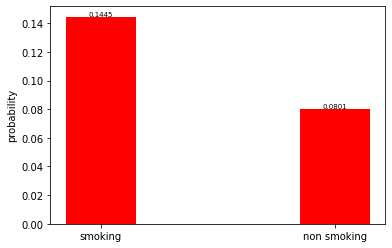

In [130]:
df_smoking = df[df['Smoking'] == 1]
df_non_smoking = df[df['Smoking'] == 0]
smoking_heart_disease_prob = []
smoking_heart_disease_prob.append(len(df_smoking[df_smoking['HeartDisease'] == 1]) / len(df_smoking))
smoking_heart_disease_prob.append(len(df_non_smoking[df_non_smoking['HeartDisease'] == 1]) / len(df_non_smoking))
pd_smoking_sta = pd.Series(smoking_heart_disease_prob, index=['smoking', 'non smoking'])

plt.figure()
index=np.arange(2)
plt.bar(pd_smoking_sta.index, pd_smoking_sta.values, width=0.3, color='red')
for a, b in zip(index,pd_smoking_sta.values):   
  plt.text(a,b,'%.4f'%b,ha='center',va='bottom',fontsize=7)
plt.ylabel('probability')
plt.show()

The relationship between whether having the habbit of drinking alcohol and the chance of getting heart disease

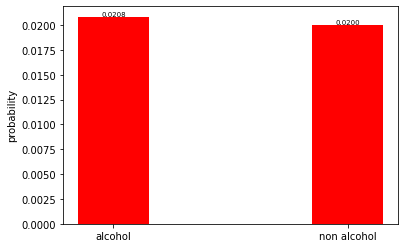

In [131]:
df_alco = df[(df['AlcoholDrinking'] == 1) & (df['AgeCategory'] < 5)]
df_non_alco = df[(df['AlcoholDrinking'] == 0) & (df['AgeCategory'] < 5)]
alco_heart_disease_prob = []
alco_heart_disease_prob.append(len(df_alco[df_alco['HeartDisease'] == 1]) / len(df_alco))
alco_heart_disease_prob.append(len(df_non_alco[df_non_alco['HeartDisease'] == 1]) / len(df_non_alco))
pd_alco_sta = pd.Series(alco_heart_disease_prob, index=['alcohol', 'non alcohol'])

plt.figure()
index=np.arange(2)
plt.bar(pd_alco_sta.index, pd_alco_sta.values, width=0.3, color='red')
for a, b in zip(index,pd_alco_sta.values):   
  plt.text(a,b,'%.4f'%b,ha='center',va='bottom',fontsize=7)
plt.ylabel('probability')
plt.show()

The relationship between whether having the habbit of doing regular physical activity and the chance of getting heart disease

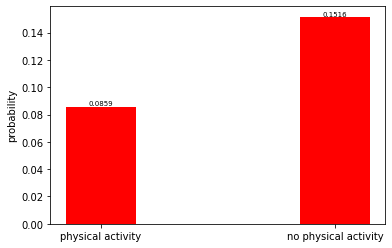

In [132]:
df_act = df[df['PhysicalActivity'] == 1]
df_non_act = df[df['PhysicalActivity'] == 0]
act_heart_disease_prob = []
act_heart_disease_prob.append(len(df_act[df_act['HeartDisease'] == 1]) / len(df_act))
act_heart_disease_prob.append(len(df_non_act[df_non_act['HeartDisease'] == 1]) / len(df_non_act))
pd_act_sta = pd.Series(act_heart_disease_prob, index=['physical activity', 'no physical activity'])

plt.figure()
index=np.arange(2)
plt.bar(pd_act_sta.index, pd_act_sta.values, width=0.3, color='red')
for a, b in zip(index,pd_act_sta.values):   
  plt.text(a,b,'%.4f'%b,ha='center',va='bottom',fontsize=7)
plt.ylabel('probability')
plt.show()

The relationship between average sleep time of humans and the chance of getting heart disease

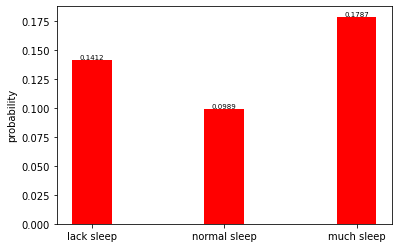

In [128]:
df_lackSleep = df[(df['SleepTime'] < 6)]
df_normalSleep = df[((df['SleepTime'] >= 6) & (df['SleepTime'] <= 9))]
df_tooMuchSleep = df[(df['SleepTime'] > 9)]
sleep_heart_disease_prob = []
sleep_list = [df_lackSleep, df_normalSleep, df_tooMuchSleep]
sleep_type = ['lack sleep', 'normal sleep', 'much sleep']
for df in sleep_list:
    sleep_heart_disease_prob.append(len(df[df['HeartDisease'] == 1]) / len(df))
pd_sleep_sta = pd.Series(sleep_heart_disease_prob, index=sleep_type)

plt.figure()
index=np.arange(len(sleep_type))
plt.bar(pd_sleep_sta.index, pd_sleep_sta.values, width=0.3, color='red')
for a, b in zip(index,pd_sleep_sta.values):   #柱子上的数字显示
  plt.text(a,b,'%.4f'%b,ha='center',va='bottom',fontsize=7)
plt.ylabel('probability')
plt.show()

**5. Spliting our data into training and testing set with a ratio of 4:1.**

In [133]:
X=data.drop(columns='HeartDisease')
y=data.HeartDisease
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

**6. Addressing imbanlance problems in our dataset.**
* Our data suffers a great imbanlance problem, as the ratio between positive and negative samples is about 1:10
* Random oversampling to the minority is performed on the traning set to balance the positive and negative samples for our model to train.
* Random oversampling will not be performed on testing set, as we believe the test must be performed on 100 percent real data.

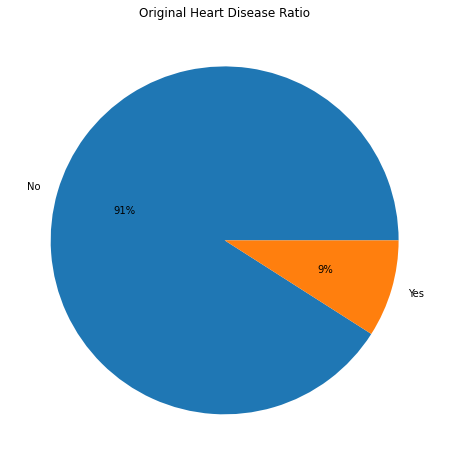

In [134]:
fig, ax = plt.subplots(1, 1,figsize =(15, 8))
ax.pie(y.value_counts(),autopct='%1.0f%%',labels=['No',"Yes"])
ax.set_title('Original Heart Disease Ratio')
plt.show()

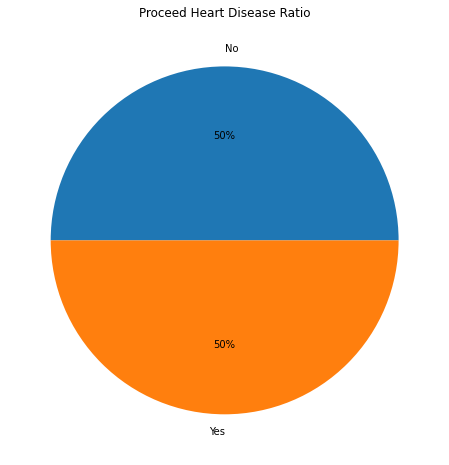

In [135]:
X_over,y_over=RandomOverSampler(random_state=42).fit_resample(X_train,y_train)
fig, ax = plt.subplots(1, 1,figsize =(15, 8))
ax.pie(y_over.value_counts(),autopct='%1.0f%%',labels=['No',"Yes"])
ax.set_title('Proceed Heart Disease Ratio')
plt.show()

## Model Selection

Initialize all the models that we have chosen for training, just for a view

In [75]:
log_reg = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
svc = LinearSVC()
ada = AdaBoostClassifier()
xg = xgboost.XGBClassifier()
mlp = MLPClassifier()
Kflod = StratifiedKFold(n_splits=7, shuffle=True, random_state=7)

**Perform Gridsearch on LogisticRegression**

In [93]:
para_logistic = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                     'solver': ['lbfgs', 'sag', 'saga']}
grid_search = GridSearchCV(estimator=log_reg, param_grid=para_logistic, cv=Kflod, scoring=['recall', 'accuracy'], refit='accuracy',
                           n_jobs=-1, verbose=2).fit(X_over,y_over)
y_pre = grid_search.predict(X_test)
print("The best parameter for logistic regression is: ", grid_search.best_params_)
print("The prediction accuracy is :", {accuracy_score(y_test, y_pre)})
print('model estimation report：\n', classification_report(y_test, y_pre))
print('model confusion matrix:\n', confusion_matrix(y_test, y_pre))

Fitting 7 folds for each of 21 candidates, totalling 147 fits
The best parameter for logistic regression is:  {'C': 0.01, 'solver': 'saga'}
The prediction accuracy is : {0.7338753928268569}
model estimation report：
               precision    recall  f1-score   support

           0       0.97      0.73      0.83     54807
           1       0.22      0.76      0.34      5334

    accuracy                           0.73     60141
   macro avg       0.59      0.75      0.59     60141
weighted avg       0.90      0.73      0.79     60141

model confusion matrix:
 [[40058 14749]
 [ 1256  4078]]


C:\Users\86138\.conda\envs\IND5003\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Perform Gridsearch on Decision Tree**

In [98]:
para_tree = {'max_depth': [5, 10, None],
             'min_samples_leaf': [2, 4, 6, 8, 10]}
grid_search = GridSearchCV(estimator=dt, param_grid=para_tree, cv=Kflod, scoring=['recall', 'accuracy'], refit='accuracy', n_jobs=-1, 
                           verbose=2).fit(X_over,y_over)
y_pre = grid_search.predict(X_test)
print("The best parameter for Decision tree is: ", grid_search.best_params_)
print("The prediction accuracy is :", {accuracy_score(y_test, y_pre)})
print('model estimation report：\n', classification_report(y_test, y_pre))
print('model confusion matrix:\n', confusion_matrix(y_test, y_pre))

Fitting 7 folds for each of 15 candidates, totalling 105 fits
The best parameter for Decision tree is:  {'max_depth': None, 'min_samples_leaf': 2}
The prediction accuracy is : {0.8452802580602251}
model estimation report：
               precision    recall  f1-score   support

           0       0.93      0.90      0.91     54807
           1       0.21      0.27      0.24      5334

    accuracy                           0.85     60141
   macro avg       0.57      0.59      0.58     60141
weighted avg       0.86      0.85      0.85     60141

model confusion matrix:
 [[49378  5429]
 [ 3876  1458]]


**Perform Gridsearch on Random forest**

In [99]:
rf = RandomForestClassifier(min_samples_leaf=2)
para_forest = {'n_estimators': [60, 80, 100, 150, 200, 300]}
grid_search = GridSearchCV(estimator=rf, param_grid=para_forest, cv=Kflod, scoring=['recall', 'accuracy'], refit='accuracy', n_jobs=-1, 
                           verbose=2).fit(X_over,y_over)
y_pre = grid_search.predict(X_test)
print("The best parameter for Random forest is: ", grid_search.best_params_)
print("The prediction accuracy is :", {accuracy_score(y_test, y_pre)})
print('model estimation report：\n', classification_report(y_test, y_pre))
print('model confusion matrix:\n', confusion_matrix(y_test, y_pre))

Fitting 7 folds for each of 6 candidates, totalling 42 fits
The best parameter for Random forest is:  {'n_estimators': 300}
The prediction accuracy is : {0.8630884089057382}
model estimation report：
               precision    recall  f1-score   support

           0       0.94      0.91      0.92     54807
           1       0.30      0.40      0.34      5334

    accuracy                           0.86     60141
   macro avg       0.62      0.66      0.63     60141
weighted avg       0.88      0.86      0.87     60141

model confusion matrix:
 [[49747  5060]
 [ 3174  2160]]


**Perform Gridsearch on Random LinearSVC**

In [100]:
para_SVC = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(estimator=svc, param_grid=para_SVC, cv=Kflod, scoring=['recall', 'accuracy'], refit='accuracy', n_jobs=-1, 
                           verbose=2).fit(X_over,y_over)
y_pre = grid_search.predict(X_test)
print("The best parameter for Linear SVC is: ", grid_search.best_params_)
print("The prediction accuracy is :", {accuracy_score(y_test, y_pre)})
print('model estimation report：\n', classification_report(y_test, y_pre))
print('model confusion matrix:\n', confusion_matrix(y_test, y_pre))

Fitting 7 folds for each of 6 candidates, totalling 42 fits
The best parameter for Linear SVC is:  {'C': 0.1}
The prediction accuracy is : {0.729851515604995}
model estimation report：
               precision    recall  f1-score   support

           0       0.97      0.73      0.83     54807
           1       0.21      0.77      0.34      5334

    accuracy                           0.73     60141
   macro avg       0.59      0.75      0.58     60141
weighted avg       0.90      0.73      0.79     60141

model confusion matrix:
 [[39781 15026]
 [ 1221  4113]]


C:\Users\86138\.conda\envs\IND5003\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


**Perform Gridsearch on Adaboost**

In [101]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), learning_rate=0.01)
para_ada = {'n_estimators': [50, 100, 200, 300, 400]}
grid_search = GridSearchCV(estimator=ada, param_grid=para_ada, cv=Kflod, scoring=['recall', 'accuracy'], refit='accuracy', n_jobs=-1, 
                           verbose=2).fit(X_over,y_over)
y_pre = grid_search.predict(X_test)
print("The best parameter for Adaboost is: ", grid_search.best_params_)
print("The prediction accuracy is :", {accuracy_score(y_test, y_pre)})
print('model estimation report：\n', classification_report(y_test, y_pre))
print('model confusion matrix:\n', confusion_matrix(y_test, y_pre))

Fitting 7 folds for each of 5 candidates, totalling 35 fits
The best parameter for Adaboost is:  {'n_estimators': 400}
The prediction accuracy is : {0.7233833823847292}
model estimation report：
               precision    recall  f1-score   support

           0       0.97      0.72      0.82     54807
           1       0.22      0.81      0.34      5334

    accuracy                           0.72     60141
   macro avg       0.60      0.76      0.58     60141
weighted avg       0.91      0.72      0.78     60141

model confusion matrix:
 [[39200 15607]
 [ 1029  4305]]


**Perform Gridsearch on MLP Classifier**

In [102]:
para_mlp = {'hidden_layer_sizes': [(5,5), (10, 10), (20, 20), (64, 64)]}
grid_search = GridSearchCV(estimator=mlp, param_grid=para_mlp, cv=Kflod, scoring=['recall','accuracy'], refit='accuracy', n_jobs=-1, 
                           verbose=2).fit(X_over,y_over)
y_pre = grid_search.predict(X_test)
print("The best parameter for MLP Classifier is: ", grid_search.best_params_)
print("The prediction accuracy is :", {accuracy_score(y_test, y_pre)})
print('model estimation report：\n', classification_report(y_test, y_pre))
print('model confusion matrix:\n', confusion_matrix(y_test, y_pre))

Fitting 7 folds for each of 4 candidates, totalling 28 fits
The best parameter for MLP Classifier is:  {'hidden_layer_sizes': (64, 64)}
The prediction accuracy is : {0.7390299462928784}
model estimation report：
               precision    recall  f1-score   support

           0       0.97      0.74      0.84     54807
           1       0.22      0.74      0.33      5334

    accuracy                           0.74     60141
   macro avg       0.59      0.74      0.59     60141
weighted avg       0.90      0.74      0.79     60141

model confusion matrix:
 [[40493 14314]
 [ 1381  3953]]


C:\Users\86138\.conda\envs\IND5003\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


**Perform Gridsearch on Xgboost**

In [104]:
other_params = {'eta': 0.3, 'n_estimators': 500, 'gamma': 0, 'max_depth': 6, 'subsample': 1, 'reg_lambda': 1}
para_1 = {'n_estimators': [50, 100, 200, 300, 400]}
xg = xgboost.XGBClassifier(**other_params)
grid_search = GridSearchCV(estimator=xg, param_grid=para_1, cv=Kflod, scoring=['recall','accuracy'], refit='recall', n_jobs=-1, 
                           verbose=2).fit(X_over,y_over)
other_params['n_estimators'] = grid_search.best_params_['n_estimators']
print(grid_search.best_score_)

para_2 = {'max_depth': [1, 3, 5, 7, 9, 10]}
xg = xgboost.XGBClassifier(**other_params)
grid_search = GridSearchCV(estimator=xg, param_grid=para_2, cv=Kflod, scoring=['recall','accuracy'], refit='accuracy', n_jobs=-1, 
                           verbose=2).fit(X_over,y_over)
other_params['max_depth'] = grid_search.best_params_['max_depth']
print(grid_search.best_score_)

para_3 = {'gamma': np.linspace(0, 1, 5)}
xg = xgboost.XGBClassifier(**other_params)
grid_search = GridSearchCV(estimator=xg, param_grid=para_3, cv=Kflod, scoring=['recall','accuracy'], refit='accuracy', n_jobs=-1, 
                           verbose=2).fit(X_over,y_over)
other_params['gamma'] = grid_search.best_params_['gamma']
print(grid_search.best_score_)

para_4 = {'subsample': np.linspace(0, 1, 5)}
xg = xgboost.XGBClassifier(**other_params)
grid_search = GridSearchCV(estimator=xg, param_grid=para_4, cv=Kflod, scoring=['recall','accuracy'], refit='accuracy', n_jobs=-1, 
                           verbose=2).fit(X_over,y_over)
other_params['subsample'] = grid_search.best_params_['subsample']
print(grid_search.best_score_)

para_5 = {'reg_lambda': np.linspace(0, 100, 6)}
xg = xgboost.XGBClassifier(**other_params)
grid_search = GridSearchCV(estimator=xg, param_grid=para_5, cv=Kflod, scoring=['recall','accuracy'], refit='accuracy',  n_jobs=-1, 
                           verbose=2).fit(X_over,y_over)
other_params['reg_lambda'] = grid_search.best_params_['reg_lambda']
print(grid_search.best_score_)

para_6 = {'eta': np.logspace(-2, 0, 10)}
xg = xgboost.XGBClassifier(**other_params)
grid_search = GridSearchCV(estimator=xg, param_grid=para_6, cv=Kflod, scoring=['recall','accuracy'], refit='accuracy', n_jobs=-1, 
                           verbose=2).fit(X_over,y_over)
other_params['eta'] = grid_search.best_params_['eta']
print(grid_search.best_score_)

y_pre = grid_search.predict(X_test)
print("The best parameter for XGboost is: ", grid_search.best_params_)
print("The prediction accuracy is :", {accuracy_score(y_test, y_pre)})
print('model estimation report：\n', classification_report(y_test, y_pre))
print('model confusion matrix:\n', confusion_matrix(y_test, y_pre))

Fitting 7 folds for each of 5 candidates, totalling 35 fits
0.8754532335174176
Fitting 7 folds for each of 6 candidates, totalling 42 fits
0.931485550747561
Fitting 7 folds for each of 5 candidates, totalling 35 fits
0.9324982982616353
Fitting 7 folds for each of 5 candidates, totalling 35 fits
0.9444020224143131
Fitting 7 folds for each of 6 candidates, totalling 42 fits
0.9490085170107786
Fitting 7 folds for each of 10 candidates, totalling 70 fits
0.9592136687538158
The best parameter for XGboost is:  {'eta': 0.5994842503189409}
The prediction accuracy is : {0.8687085349428842}
model estimation report：
               precision    recall  f1-score   support

           0       0.93      0.93      0.93     54807
           1       0.26      0.27      0.26      5334

    accuracy                           0.87     60141
   macro avg       0.60      0.60      0.60     60141
weighted avg       0.87      0.87      0.87     60141

model confusion matrix:
 [[50823  3984]
 [ 3912  1422]]


Try again with Xgboost, but let's set the refit to recall, and select the model with highest recall value.<p>
    Based on the previous training with xgboost, it took quite a long time, we first give a rough search on 2 parameters

In [105]:
para = {'n_estimators': [50, 100, 200, 300, 400]}
xg = xgboost.XGBClassifier()
grid_search = GridSearchCV(estimator=xg, param_grid=para, cv=Kflod, scoring=['recall','accuracy'], refit='recall', n_jobs=-1, 
                           verbose=2).fit(X_over,y_over)
y_pre = grid_search.predict(X_test)
print("The best parameter for XGboost is: ", grid_search.best_params_)
print("The prediction accuracy is :", {accuracy_score(y_test, y_pre)})
print('model estimation report：\n', classification_report(y_test, y_pre))
print('model confusion matrix:\n', confusion_matrix(y_test, y_pre))

Fitting 7 folds for each of 5 candidates, totalling 35 fits
The best parameter for XGboost is:  {'n_estimators': 400}
The prediction accuracy is : {0.7670474385194792}
model estimation report：
               precision    recall  f1-score   support

           0       0.96      0.77      0.86     54807
           1       0.23      0.70      0.35      5334

    accuracy                           0.77     60141
   macro avg       0.60      0.73      0.60     60141
weighted avg       0.90      0.77      0.81     60141

model confusion matrix:
 [[42420 12387]
 [ 1623  3711]]


In [107]:
para = {'max_depth': [1, 4, 7, 10, None]}
xg = xgboost.XGBClassifier(n_estimators=400)
grid_search = GridSearchCV(estimator=xg, param_grid=para, cv=Kflod, scoring=['recall','accuracy'], refit='recall', n_jobs=-1, 
                           verbose=2).fit(X_over,y_over)
y_pre = grid_search.predict(X_test)
print("The best parameter for XGboost is: ", grid_search.best_params_)
print("The prediction accuracy is :", {accuracy_score(y_test, y_pre)})
print('model estimation report：\n', classification_report(y_test, y_pre))
print('model confusion matrix:\n', confusion_matrix(y_test, y_pre))

Fitting 7 folds for each of 5 candidates, totalling 35 fits
The best parameter for XGboost is:  {'max_depth': 10}
The prediction accuracy is : {0.8440996990405879}
model estimation report：
               precision    recall  f1-score   support

           0       0.94      0.89      0.91     54807
           1       0.26      0.40      0.31      5334

    accuracy                           0.84     60141
   macro avg       0.60      0.64      0.61     60141
weighted avg       0.88      0.84      0.86     60141

model confusion matrix:
 [[48642  6165]
 [ 3211  2123]]


As we can see, when we keep n_estimators as the optimal number and performs gridsearch on max_depth, the recall value decreased to 0.4, this is because the local optimal happens. However, the Xgboost takes so many time that we cannot do gridsearch on all parameters together. There we keep the Xgboost with 400 estimators as our model for Xgboost,to compare with other models.

The figure below shows the evaluation performance among all models chosen.<p>
    **Adaboost is chosen as our final and optimal model**

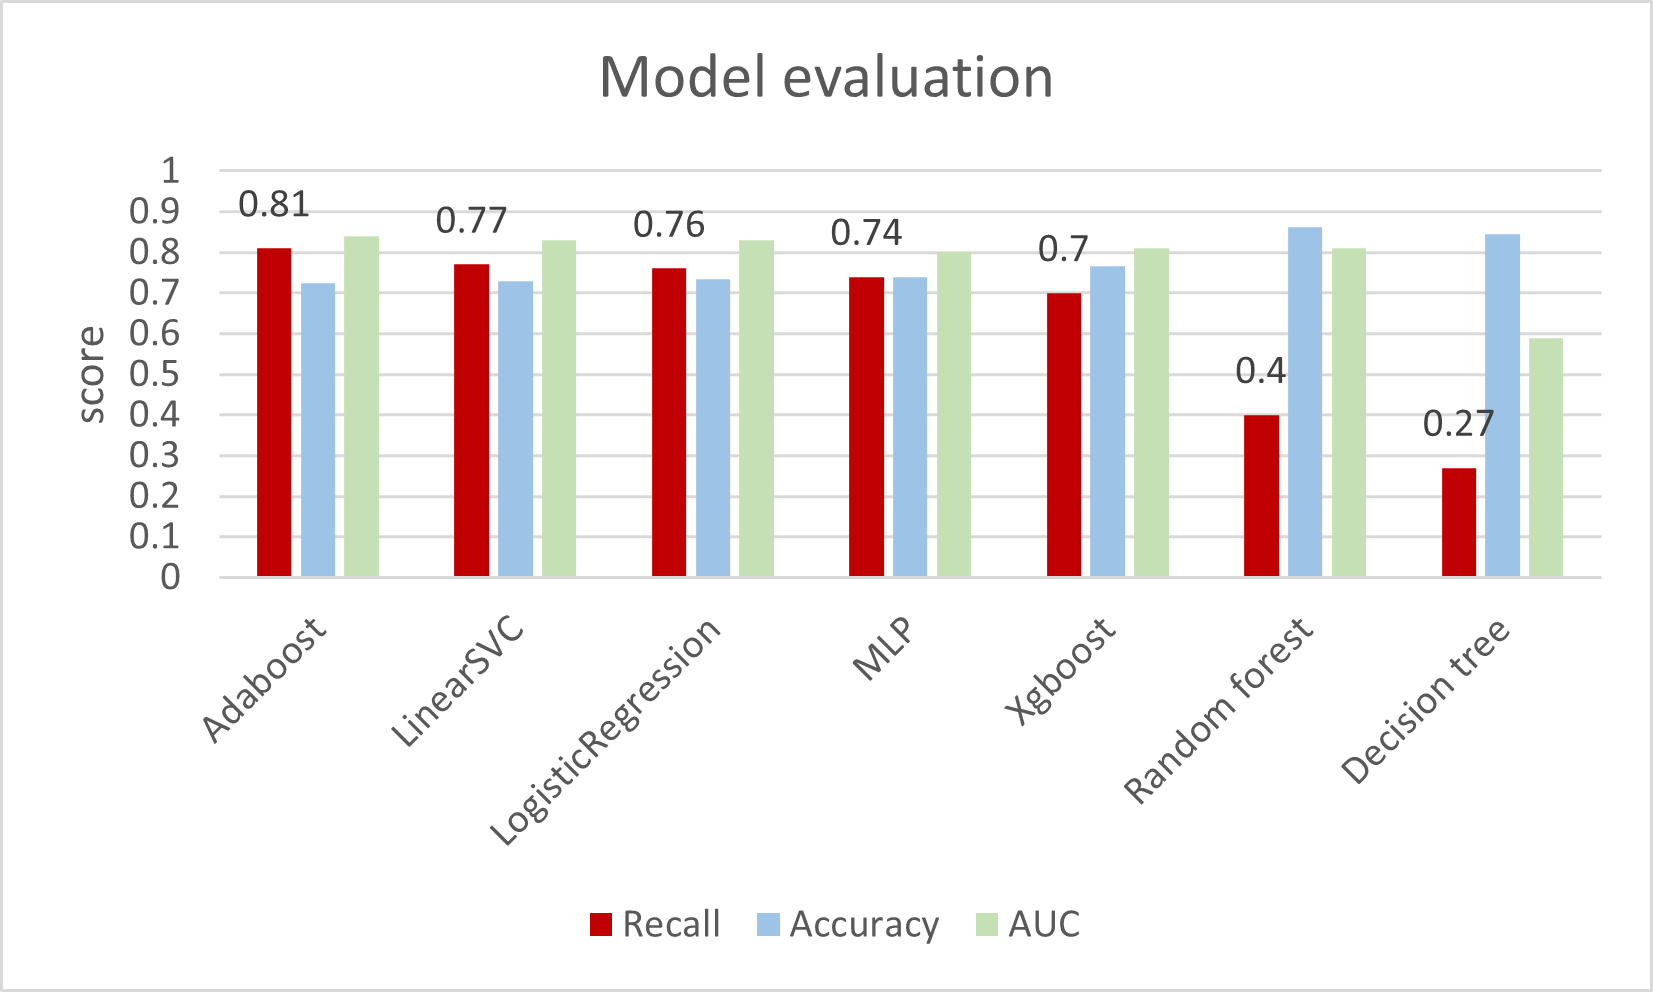

Then we visualize the rankings of the feature importance to give more analysis for our next bisiness question. The feature imporatance figure is shown below

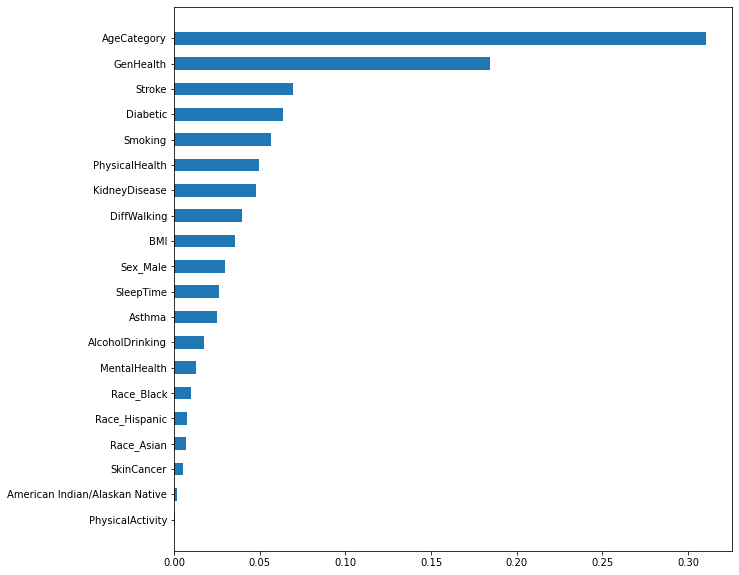

In [136]:
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),  n_estimators=400, learning_rate=0.01).fit(X_over, y_over)
fea_ = np.sort(model.feature_importances_)
fea_name = ['PhysicalActivity', 'American Indian/Alaskan Native',  'SkinCancer', 'Race_Asian',
            'Race_Hispanic', 'Race_Black', 'MentalHealth', 'AlcoholDrinking', 'Asthma',  'SleepTime',
            'Sex_Male', 'BMI', 'DiffWalking', 'KidneyDisease', 'PhysicalHealth', 'Smoking', 'Diabetic',
            'Stroke', 'GenHealth', 'AgeCategory']
plt.figure(figsize=(10, 10))
plt.barh(fea_name, fea_, height=0.5)
plt.show()

## Visualization of the data analysis based on our model

Based on the ranking of feature imporatance given by our model, we can conclude the top 5 external indicators that affect the chance of having heartdisease.<p>
    Here, an analysis is performed to give a overview on if an individual is exposed to more than 2 of thses external risk factors, what is his chances of having heartdisease

0         Smoking & No Stroke & No Diff & Diabetic & No ...
1         Non Smoking & Stroke & No Diff & No Diabetic &...
2         Smoking & No Stroke & No Diff & Diabetic & No ...
3         Non Smoking & No Stroke & No Diff & No Diabeti...
4         Non Smoking & No Stroke & Diff & No Diabetic &...
                                ...                        
319790    Smoking & No Stroke & Diff & Diabetic & No Kid...
319791    Smoking & No Stroke & No Diff & No Diabetic & ...
319792    Non Smoking & No Stroke & No Diff & No Diabeti...
319793    Non Smoking & No Stroke & No Diff & No Diabeti...
319794    Non Smoking & No Stroke & No Diff & No Diabeti...
Name: group, Length: 319795, dtype: object
                                                group HeartDisease    percent
0   Non Smoking & No Stroke & Diff & Diabetic & Ki...           No  63.057325
1   Non Smoking & No Stroke & Diff & Diabetic & Ki...          Yes  36.942675
2   Non Smoking & No Stroke & Diff & Diabetic & No...          

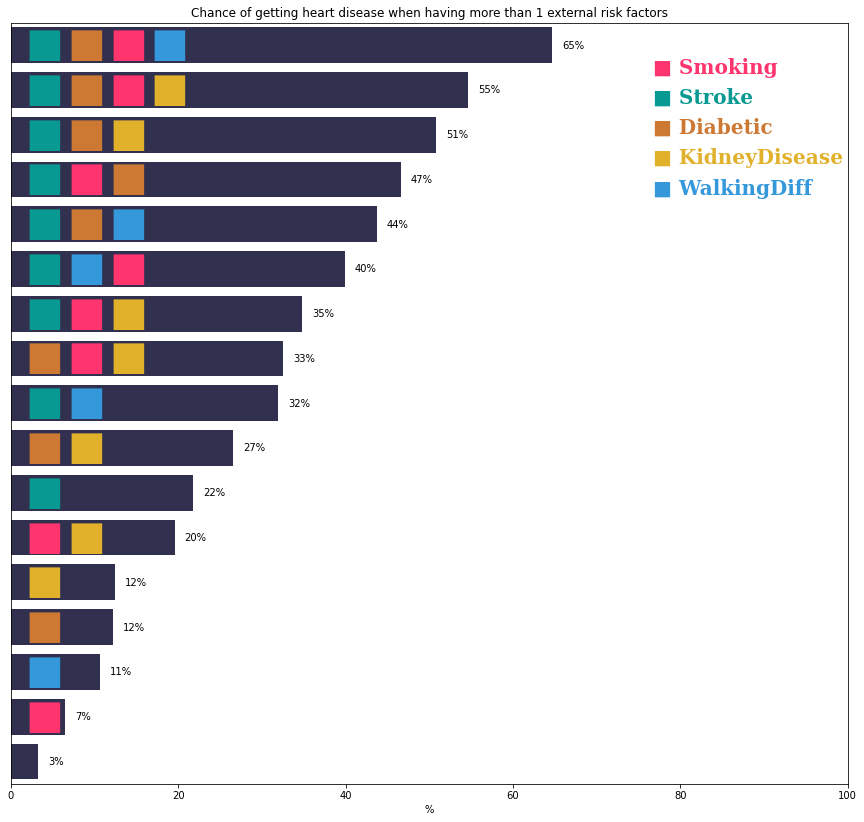

In [97]:
df = pd.read_csv(r'D:\semester1\IND5022\pythonProject\heart_2020.csv')
dk = df.copy()
dk.Smoking = dk.Smoking.apply(lambda x : 'Smoking' if x == 'Yes' else 'Non Smoking')
dk.Stroke = dk.Stroke.apply(lambda x : 'Stroke' if x == 'Yes' else 'No Stroke')
dk.DiffWalking = dk.DiffWalking.apply(lambda x : 'Diff' if x == 'Yes' else 'No Diff')
dk.Diabetic = dk.Diabetic.apply(lambda x : 'Diabetic' if x == 'Yes' else 'No Diabetic')
dk.KidneyDisease = dk.KidneyDisease.apply(lambda x : 'KidneyDisease' if x == 'Yes' else 'No KidneyDisease')

dk['group'] = dk.Smoking + ' & ' + dk.Stroke + ' & ' + dk.DiffWalking + ' & ' + dk.Diabetic + ' & ' + dk.KidneyDisease
print(dk['group'])
df_plot = dk.groupby('group')['HeartDisease'].value_counts(normalize = True).mul(100)
df_plot = df_plot.rename('percent').reset_index()
print(df_plot)

h = df_plot[df_plot['HeartDisease'] == 'Yes'].drop(['HeartDisease'],axis=1)
h.set_index('group',inplace=True)
print(h)
k = h.iloc[[24, 28, 12, 29, 9, 27, 30, 20, 11, 4, 15, 22, 6, 3, 5, 23, 7]]
print(k)
fig, ax = plt.subplots(1, 1, figsize =(15, 14))
ax = sns.barplot(y = k.index, x=k.percent.values, color='#2c2c54')
ax.bar_label(ax.containers[0], fmt='%.f%%', padding=10)
colors={
    'smoking':'#fe346e',
    'stroke':'#079992',
    'diabetic':'#cd7933',
    'kidney':'#e1b12c',
    'Walking diff':'#3498db'
}
y=0
#dk['group'] = dk.Smoking + ' & ' + dk.Stroke + ' & ' + dk.DiffWalking + ' & ' + dk.Diabetic + ' & ' + dk.KidneyDisease
axes=[
    ['stroke', 'diabetic', 'smoking', 'Walking diff'],
    ['stroke', 'diabetic', 'smoking', 'kidney'],
    ['stroke', 'diabetic', 'kidney'],
    ['stroke', 'smoking', 'diabetic'],
    ['stroke', 'diabetic', 'Walking diff'],
    ['stroke', 'Walking diff', 'smoking'],
    ['stroke', 'smoking', 'kidney'],
    ['diabetic', 'smoking', 'kidney'],
    ['stroke', 'Walking diff'],
    ['diabetic', 'kidney'],
    ['stroke'],
    ['smoking', 'kidney'],
    ['kidney'],
    ['diabetic'],
    ['Walking diff'],
    ['smoking'],
    []
]
for axo in axes:
    x=4
    for i in axo:
        ax.annotate('■',
        ha='center', va='center', fontsize=40, color=colors[i], xy=(x, y),font='Serif')
        x+=5
    y+=1
ax.set_xlabel('%')
ax.axes.get_yaxis().set_visible(False)
ax.set(xlim=(0, 100))

fig.text(0.72, 0.83, '■ Smoking', {'font': 'Serif', 'weight': 'bold', 'size': '20','weight':'bold','style':'normal', 'color':colors['smoking']})
fig.text(0.72, 0.80, '■ Stroke', {'font': 'Serif', 'weight': 'bold', 'size': '20','weight':'bold','style':'normal', 'color':colors['stroke']})
fig.text(0.72, 0.77, '■ Diabetic', {'font': 'Serif', 'weight': 'bold', 'size': '20','weight':'bold','style':'normal', 'color':colors['diabetic']})
fig.text(0.72, 0.74, '■ KidneyDisease', {'font': 'Serif', 'weight': 'bold', 'size': '20','weight':'bold','style':'normal', 'color':colors['kidney']})
fig.text(0.72, 0.71, '■ WalkingDiff', {'font': 'Serif', 'weight': 'bold', 'size': '20','weight':'bold','style':'normal', 'color':colors['Walking diff']})
ax.set_title('Chance of getting heart disease when having more than 1 external risk factors')
plt.show()